In [148]:
import numpy as np 
import pandas as pd
from datetime import datetime
from pathlib import Path
import xarray as xr
import matplotlib.pyplot as plt
import geopandas as gpd
import matplotlib.colors as mcolors
from pyproj import datadir
from scipy.stats import pearsonr
datadir.set_data_dir("/home/jupyter-daniela/.conda/envs/peru_environment/share/proj")


In [149]:
class CatchesRhoCorrelator:
    def __init__(self, data_dir):
        self.data_dir = Path(data_dir)
        self.catches_data = pd.DataFrame()
        self.rho_data = xr.Dataset()
        self.rho_weekly = xr.Dataset()
        self.rho_df = pd.DataFrame()
        self.merge_datasets = pd.DataFrame()
        self.results = pd.DataFrame()
        self.grouped = pd.DataFrame()
        self.results_beta = pd.DataFrame()
        
    def load_catches_data(self, filename):
        self.catches_data = pd.read_csv(self.data_dir / filename)

    def load_rho_data(self, filepath):
        self.rho_data = xr.open_dataset(filepath)

    def preprocess_catches_data(self):
        def parse_temporada(row):
            parte, anio = row.split()
            return int(anio)
        self.catches_data["anio"] = self.catches_data["temporada"].apply(parse_temporada)
        self.catches_data["fecha"] = pd.to_datetime(
            self.catches_data["anio"].astype(str), format="%Y"
        ) + pd.to_timedelta((self.catches_data["semana"] - 1) * 7, unit="D")

    def preprocess_rho_data(self):
        years = np.arange(2015, 2025)
        ds_list = []
        for y in years:
            ds_year = self.rho_data.sel(time=slice(f"{y}-01-01", f"{y}-12-31"))
            ds_year_weekly = ds_year.resample(time="7D", origin=f"{y}-01-01").max()
            ds_list.append(ds_year_weekly)
        rho_weekly = xr.concat(ds_list, dim="time")
        semanas = rho_weekly["time"].dt.isocalendar().week
        mask_temporada1 = (semanas >= 14) & (semanas <= 32)
        mask_temporada2 = (semanas >= 42) | (semanas <= 5)
        mask_temporadas = mask_temporada1 | mask_temporada2
        self.rho_weekly = rho_weekly.where(mask_temporadas, drop=True)

    def convert_xarray_to_dataframe(self):
        if "rho_surface" not in self.rho_weekly.data_vars:
            raise ValueError("El dataset no contiene la variable 'rho_surface'")
        df = self.rho_weekly["rho_surface"].to_dataframe().reset_index()
        df["semana"] = df["time"].dt.isocalendar().week
        df.rename(columns={"latitude": "lat_bin", "longitude": "lon_bin", "time": "fecha"}, inplace=True)
        self.rho_df = df
    
    def merge_datasets_catches_rho(self):
        if self.catches_data.empty or self.rho_df.empty:
            raise ValueError("Ambos datasets deben estar cargados y preprocesados")
        merged = pd.merge(
            self.catches_data[["fecha", "lat_bin", "lon_bin", "suma_pescado", "temporada"]],
            self.rho_df[["fecha", "lat_bin", "lon_bin", "rho_surface"]],
            on=["fecha", "lat_bin", "lon_bin"],
            how="inner"
        )
        self.merge_datasets = merged[merged["suma_pescado"] != 0]
    
    def grouped_merged(self, step=3):
        merged = self.merge_datasets
        if step == 1:
            self.grouped = merged.copy()
            return
        df = merged.copy()
        df["lat_idx"] = df["lat_bin"].rank(method="dense").astype(int)
        df["lon_idx"] = df["lon_bin"].rank(method="dense").astype(int)
        df["lat_block"] = df["lat_idx"] // step
        df["lon_block"] = df["lon_idx"] // step
        df["lat_center"] = df.groupby("lat_block")["lat_bin"].transform("mean")
        df["lon_center"] = df.groupby("lon_block")["lon_bin"].transform("mean")
        grouped = (
            df.groupby(["fecha","temporada","lat_block","lon_block"], as_index=False)
            .agg({
                "suma_pescado": "sum",
                "rho_surface": "mean",
                "lat_center": "first",
                "lon_center": "first"
            })
            .rename(columns={"lat_center": "lat_bin", "lon_center": "lon_bin"})
        )
        self.grouped = grouped

    def correlate(self):
        results = []
        grouped = self.grouped
        for (lat, lon), df_group in grouped.groupby(["lat_bin", "lon_bin"]):
            df_group = df_group[["suma_pescado", "rho_surface"]].dropna()
            n_registros = df_group.shape[0]
            if n_registros > 21:
                corr, pval = pearsonr(df_group["suma_pescado"], df_group["rho_surface"])
                signif = pval < 0.2
                results.append({
                    "lat": lat,
                    "lon": lon,
                    "correlation": corr,
                    "p_value": pval,
                    "significant": signif,
                    "n_registros": n_registros
                })
        self.results = pd.DataFrame(results)

    def save_results(self, output_filename):
        self.results.to_csv(self.data_dir / output_filename, index=False)

    def visualizar_correlacion(self, shapefile_path=None, bathymetry_path=None, mode="grid", if_significant=True):
        if self.results.empty:
            raise ValueError("Primero debes correr el método correlate()")
        
        data = self.results
        if if_significant:
            data = data[data["significant"]]

        fig = plt.figure(figsize=(8, 8))
        ax = plt.axes([0.05, 0.05, 0.85, 0.9])

        if shapefile_path:
            boundary = gpd.read_file(shapefile_path)
            boundary.plot(ax=ax, facecolor="lightgrey", edgecolor="black", linewidth=0.5)
        
        if bathymetry_path:
            bathy = xr.open_dataset(bathymetry_path)
            bathy = bathy.sel(lon=slice(-83, -74.5), lat=slice(-16, -4))
            
            bathy_mesh = ax.pcolormesh(
                bathy["lon"], bathy["lat"], bathy["elevation"],
                cmap="Blues_r", alpha=0.3, shading="auto",
                vmin=-6000, vmax=0
            )

        if mode == "scatter":
            grid = data.pivot_table(index="lat", columns="lon", values="correlation")
            
            lons = grid.columns.values
            lats = grid.index.values
            Z = grid.values
            Z[Z < -0.3] = np.nan
            sc = ax.scatter(
                *np.meshgrid(lons, lats, indexing="xy"),
                c=Z.flatten(),
                cmap="RdBu_r",
                vmin=-1, vmax=1,
                s=50
            )
            plt.colorbar(sc, ax=ax, label="Correlación")

        elif mode == "grid":
            sig_results = data[data["significant"]]
            grid = sig_results.pivot_table(index="lat", columns="lon", values="correlation")
            lons = grid.columns.values
            lats = grid.index.values
            Z = grid.values 
            Z[Z < -0.3] = np.nan
            levels = np.linspace(-.8, .8, 17)
            norm = mcolors.BoundaryNorm(boundaries=levels, ncolors=256)
            mesh = ax.pcolormesh(lons, lats, Z, cmap="RdBu_r", norm=norm, shading="auto")
            cax = plt.axes([0.92, 0.1, 0.02, 0.8])
            plt.colorbar(mesh, cax=cax, ticks=levels, label="Correlación")
        else:
            raise ValueError("mode debe ser 'scatter' o 'grid'")
        ax.set_xlim([-83, -74.5])
        ax.set_ylim([-16, -4])
        ax.set_xlabel("Longitud")
        ax.set_ylabel("Latitud")
        ax.set_title("Mapa de correlación capturas–ρ", fontsize=10, loc="left")
        plt.show()


    def calcular_beta_espacial(self, if_significant=True, if_difference_catches=True):
        if self.grouped.empty:
            raise ValueError("Primero debes ejecutar grouped_merged()")
        if self.results.empty:
            raise ValueError("Primero debes ejecutar correlate()")
        if if_significant:
            results_filtered = self.results[self.results["significant"]]
        else:
            results_filtered = self.results
        coords_validos = set(zip(results_filtered["lat"], results_filtered["lon"]))
        resultados = []
        for (lat, lon), df_group in self.grouped.groupby(["lat_bin", "lon_bin"]):
            if (lat, lon) not in coords_validos:
                continue
            df_group = df_group[(df_group["suma_pescado"] > 0) & df_group["rho_surface"].notna()]
            if len(df_group) > 21:
                x = df_group["rho_surface"].values
                y = df_group["suma_pescado"].values
                if if_difference_catches:
                    y = y - np.mean(y)
                A = np.vstack([x, np.ones(len(x))]).T
                beta, alpha = np.linalg.lstsq(A, y, rcond=None)[0]
                resultados.append({
                    "lat": lat, 
                    "lon": lon, 
                    "beta": beta, 
                    "alpha": alpha, 
                    "n": len(df_group)
                    })
        self.results_beta = pd.DataFrame(resultados)

    def visualizar_beta(self, shapefile_path=None, bathymetry_path=None):
        if not hasattr(self, "results_beta") or self.results_beta.empty:
            raise ValueError("Primero debes ejecutar calcular_beta_espacial()")

        fig = plt.figure(figsize=(8, 8))
        ax = plt.axes([0.05, 0.05, 0.85, 0.9])
        if shapefile_path:
            boundary = gpd.read_file(shapefile_path)
            boundary.plot(ax=ax, facecolor="lightgrey", edgecolor="black", linewidth=0.5)

        if bathymetry_path:
            bathy = xr.open_dataset(bathymetry_path)
            bathy = bathy.sel(lon=slice(-83, -74.5), lat=slice(-16, -4))
            
            bathy_mesh = ax.pcolormesh(
                bathy["lon"], bathy["lat"], bathy["elevation"],
                cmap="Blues_r", alpha=0.3, shading="auto",
                vmin=-6000, vmax=0
            )
        grid = self.results_beta.pivot_table(index="lat", columns="lon", values="beta")
        lons = grid.columns.values
        lats = grid.index.values
        Z = grid.values
        vmin, vmax = np.nanpercentile(Z, [5, 95])
        Z[Z < -3000] = np.nan
        print(f"Media beta: {np.nanmean(Z)}")
        print(f"Celdas validas: {np.count_nonzero(~np.isnan(Z))}")
        vmin=0
        vmax=8000

        mesh = ax.pcolormesh(lons, lats, Z, cmap="Reds", shading="auto", vmin=vmin, vmax=vmax)
        cax = plt.axes([0.92, 0.1, 0.02, 0.8])
        plt.colorbar(mesh, cax=cax, label="Beta producción vs densidad")
        ax.set_xlim([-83, -74.5])
        ax.set_ylim([-16, -4])
        ax.set_xlabel("Longitud")
        ax.set_ylabel("Latitud")
        ax.set_title("Mapa de coeficiente beta (pendiente regresión)", fontsize=10, loc="left")
        plt.show()

    def visualizar_distribucion_anomalias(self, if_significant=True, bins=30, show_kde=True):

        if self.results.empty:
            raise ValueError("Primero debes correr el método correlate()")
        if not hasattr(self, "rho_data"):
            raise AttributeError("El objeto no tiene datos de rho disponibles.")

        data = self.results
        if if_significant:
            data = data[data["significant"]]

        if data.empty:
            raise ValueError("No hay puntos para mostrar la distribución.")

        selected_lats = data["lat"].values
        selected_lons = data["lon"].values

        rho_sel = self.rho_data.sel(latitude=selected_lats, longitude=selected_lons, method="nearest")
        rho_anoms = rho_sel["rho_surface"].values.flatten()

        fig, ax = plt.subplots(figsize=(8, 5))
        ax.hist(rho_anoms, bins=bins, density=True, alpha=0.6, color="steelblue", edgecolor="white")
        
        if show_kde:
            from scipy.stats import gaussian_kde
            kde = gaussian_kde(rho_anoms[~np.isnan(rho_anoms)])
            x_grid = np.linspace(np.nanmin(rho_anoms), np.nanmax(rho_anoms), 200)
            ax.plot(x_grid, kde(x_grid), color="darkblue", lw=.5)

        p95 = np.nanpercentile(rho_anoms, 95)
        p99 = np.nanpercentile(rho_anoms, 99)

        ax.axvline(p95, color="orange", linestyle="--", label=f"P90: {p95:.2f}")
        ax.axvline(p99, color="red", linestyle="--", label=f"P95: {p99:.2f}")

        ax.axvline(np.nanmean(rho_anoms), color="k", linestyle="--", label=f"Media: {np.nanmean(rho_anoms):.2f}")
        ax.set_xlabel("Anomalía de densidad (kg/m³)")
        ax.set_ylabel("Densidad de probabilidad")
        ax.set_title("Distribución de anomalías de densidad en puntos seleccionados", loc='left', fontsize=11)
        ax.set_xlim([-2,2])
        ax.legend(loc="upper left", fontsize=8, frameon=False)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        plt.show()




In [150]:

data_dir = "/home/jupyter-daniela/suyana/peru_production/outputs/"
rho_path = "/home/jupyter-daniela/suyana/peru_production/features/SSD_weekly_anom_2015-2024_4N_74W_16S_83W_0.25deg.nc"
crc = CatchesRhoCorrelator(data_dir)


In [151]:

crc.load_catches_data("calas_grillado_semanal_grilla_SSS.csv")
crc.load_rho_data(rho_path)
crc.preprocess_catches_data()
crc.preprocess_rho_data()
crc.convert_xarray_to_dataframe()
crc.merge_datasets_catches_rho()
crc.grouped_merged(step=1)
crc.correlate()


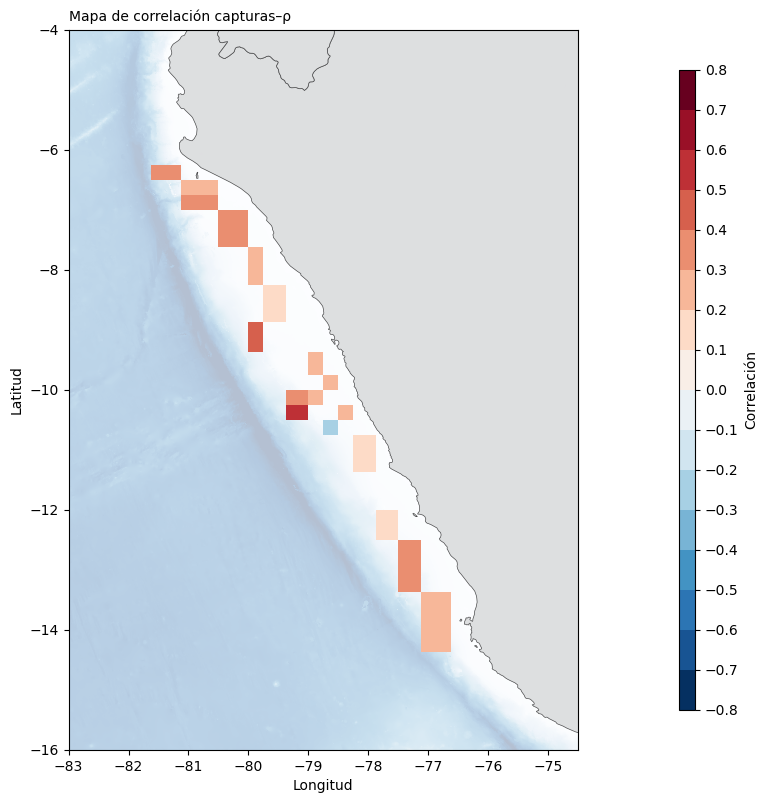

In [152]:
crc.visualizar_correlacion(
    shapefile_path="/home/jupyter-daniela/suyana/geometries/ne_10m_admin_0_countries/ne_10m_admin_0_countries.shp",
    bathymetry_path="/home/jupyter-daniela/suyana/geometries/bathymetry/gebco_2024_n-3.2_s-19.4_w-84.6_e-67.8.nc",
    mode="grid"
)

Media beta: 4322.798985264325
Celdas validas: 18


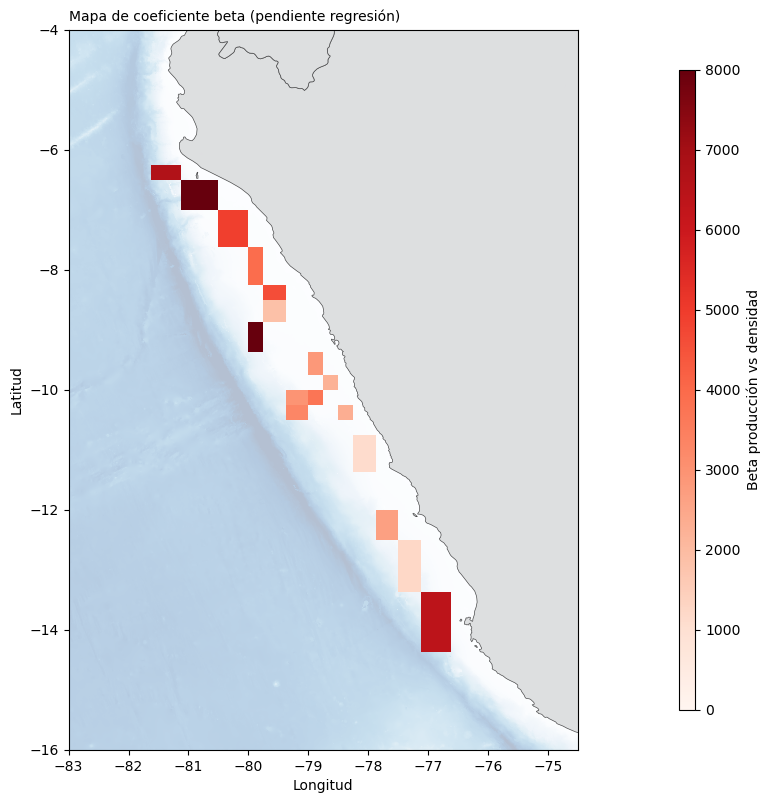

In [153]:
crc.calcular_beta_espacial(if_significant=True, if_difference_catches=True)
crc.visualizar_beta(shapefile_path="/home/jupyter-daniela/suyana/geometries/ne_10m_admin_0_countries/ne_10m_admin_0_countries.shp",
                        bathymetry_path="/home/jupyter-daniela/suyana/geometries/bathymetry/gebco_2024_n-3.2_s-19.4_w-84.6_e-67.8.nc",
)

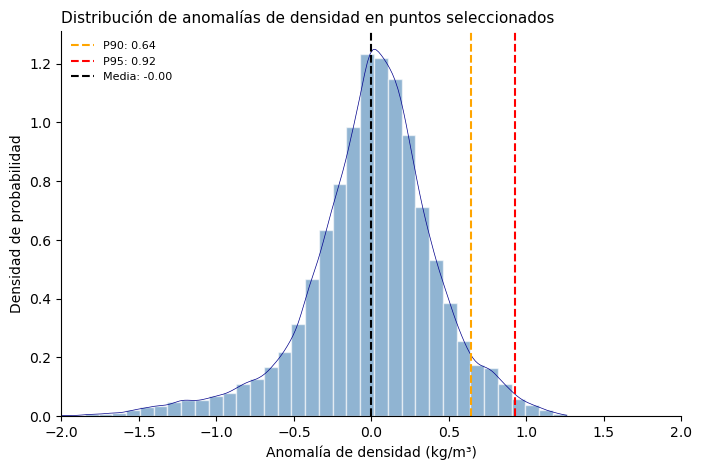

In [154]:
crc.visualizar_distribucion_anomalias(if_significant=True, bins=40, show_kde=True)
